# Corridor Detection Diagnostics

In [1]:
from pathlib import Path
import sys

REPO_ROOT = Path.cwd().resolve()
SRC_CANDIDATES = [
    REPO_ROOT / 'src',
    REPO_ROOT.parent / 'src',
    (REPO_ROOT / '..' / 'src').resolve(),
]

for candidate in SRC_CANDIDATES:
    if candidate.exists():
        src_path = candidate.resolve()
        break
else:
    raise RuntimeError('Could not locate the package src directory. Update the path setup cell.')

if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

print(f'Added {src_path} to sys.path')

Added /groups/spruston/home/moharb/DELTA_Behavior/src to sys.path


In [2]:

import pandas as pd
import matplotlib.pyplot as plt

from behavioral_analysis.io.json_parser import parse_json_file
from behavioral_analysis.io.dataframe_builder import extract_events_by_type
from behavioral_analysis.processing import (
    compute_corridor_artifacts,
    detect_corridors_simple,
    add_corridor_info_to_events,
)

plt.style.use('seaborn-v0_8')
from IPython.display import display


In [3]:

JSON_PATH = Path('/groups/spruston/home/moharb/DELTA_Behavior/Log BM35 2025-09-22 session 1.json')

if not JSON_PATH.exists():
    raise FileNotFoundError(f"JSON log not found: {JSON_PATH}")

print(f'Loading events from: {JSON_PATH.name}')
raw_events = parse_json_file(JSON_PATH, verbose=False)
frames = extract_events_by_type(raw_events, verbose=False)

print(f"Total events: {len(raw_events):,}")
print(f"Event types: {', '.join(sorted(frames.keys()))}")


Loading events from: Log BM35 2025-09-22 session 1.json
Total events: 241,714
Event types: Cue Result, Cue State, Info, Lick, Linear Controller Settings, Log, Path Position, Position, Reward, Start Period


In [4]:

corridor_info, position_with_corridors = detect_corridors_simple(
    cue_df=frames.get('Cue State'),
    position_df=frames.get('Path Position'),
    corridor_length_cm=500.0,
    verbose=True,
    cue_result_df=frames.get('Cue Result'),
)

artifacts = compute_corridor_artifacts(
    cue_state_df=frames.get('Cue State'),
    position_df=frames.get('Path Position'),
    cue_result_df=frames.get('Cue Result'),
    verbose=False,
)

cue_matches = artifacts.cue_matches
position_loops = artifacts.position_loops

updated_frames = add_corridor_info_to_events(
    dataframes={key: df.copy() for key, df in frames.items()},
    corridor_info=corridor_info,
    corridor_length_cm=500.0,
    verbose=False,
    position_df=position_with_corridors,
)

print(f"Corridors detected: {len(corridor_info)}")
print(f"Position loops: {len(position_loops)}")
print(f"Matched cues: {0 if cue_matches is None else len(cue_matches)}")


Detecting corridor structure...
  Detected 57 position-based corridor loops
Matching 402 Cue_State events to 395 Cue_Result events...
  Matched 395 cues (98.3%)
  Unmatched (not hit): 7 cues
  Note: 1 corridor(s) do not contain 7 cue hits (IDs: 56)
  Detected 56 teleports, created cumulative position
  Assigned corridor IDs to 95200/95200 position events (100.0%)
  ✓ Global position is monotonically increasing
Corridors detected: 57
Position loops: 57
Matched cues: 395


In [5]:

cols = [
    'corridor_id',
    'start_time',
    'end_time',
    'first_cue_time',
    'last_cue_time',
    'num_cue_results',
    'num_matched_cues',
    'loop_complete',
]

if not corridor_info.empty:
    display(corridor_info[cols].head(12))
else:
    print('Corridor summary unavailable.')


,corridor_id,start_time,end_time,first_cue_time,last_cue_time,num_cue_results,num_matched_cues,loop_complete
0,0,954.9052,45650.490001,22231.10,45650.49,7,7,True
1,1,22231.2800,81431.450001,52474.25,81431.45,7,7,True
2,2,52474.3000,113792.600001,84919.58,113792.60,7,7,True
3,3,84919.6300,144303.200001,118963.00,144303.20,7,7,True
4,4,118963.0000,162851.800001,146804.40,162851.80,7,7,True
5,5,146804.5000,184270.200001,165521.50,184270.20,7,7,True
6,6,165521.6000,204754.400001,185771.40,204754.40,7,7,True
7,7,185771.4000,222871.300001,206972.30,222871.30,7,7,True
8,8,206972.4000,265222.200001,229291.50,265222.20,7,7,True
9,9,229291.6000,297349.500001,273113.40,297349.50,7,7,True


In [6]:

cue_state_counts = artifacts.cue_state_with_corridors['corridor_id'].value_counts().sort_index()
cue_result_counts = artifacts.cue_result_with_corridors['corridor_id'].value_counts().sort_index()
counts_df = pd.DataFrame({
    'cue_states': cue_state_counts,
    'cue_results': cue_result_counts,
}).fillna(0).astype(int)

counts_df['all_seven'] = counts_df['cue_results'] == 7

display(counts_df.head(20))

non_standard = counts_df[counts_df['cue_results'] != 7]
if not non_standard.empty:
    print('Corridors missing full 7 hits:')
    display(non_standard)


,cue_states,cue_results,all_seven
0,7,7,True
1,7,7,True
2,7,7,True
3,7,7,True
4,7,7,True
5,7,7,True
6,7,7,True
7,7,7,True
8,7,7,True
9,7,7,True


Corridors missing full 7 hits:


,cue_states,cue_results,all_seven
56,7,3,False
57,3,0,False


In [7]:

if 'Cue Result' in updated_frames:
    display(updated_frames['Cue Result'][['corridor_id', 'cue_index', 'id', 'time', 'position', 'position_cm', 'global_position_cm']].head(14))
else:
    print('Cue Result table not available.')


,corridor_id,cue_index,id,time,position,position_cm,global_position_cm
0,0,0,0,22231.10,8959,35.836,35.836
1,0,1,1,26500.94,15039,60.156,60.156
2,0,2,2,29803.74,20787,83.148,83.148
3,0,3,3,34191.55,28561,114.244,114.244
4,0,4,4,38344.35,36580,146.320,146.320
5,0,5,5,41298.59,41337,165.348,165.348
6,0,6,6,45650.49,47585,190.340,190.340
7,1,0,0,52474.25,6726,26.904,526.904
8,1,1,1,61799.43,15114,60.456,560.456
9,1,2,2,64034.04,19235,76.940,576.940


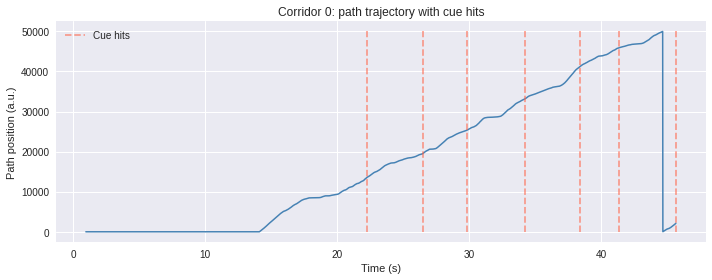

In [8]:

path_position_df = updated_frames.get('Path Position')
cue_results_df = artifacts.cue_result_with_corridors

if path_position_df is not None and not corridor_info.empty and cue_results_df is not None:
    corridor_id = 0
    loop = corridor_info[corridor_info['corridor_id'] == corridor_id].iloc[0]

    mask = (path_position_df['time'] >= loop['start_time']) & (path_position_df['time'] <= loop['end_time'])
    subset = path_position_df.loc[mask, ['time', 'position']].copy()
    subset['time_seconds'] = subset['time'] / 1000.0

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(subset['time_seconds'], subset['position'], color='steelblue', linewidth=1.5)

    hits = cue_results_df[cue_results_df['corridor_id'] == corridor_id]
    if not hits.empty:
        ax.vlines(hits['time'] / 1000.0, ymin=subset['position'].min(), ymax=subset['position'].max(),
                  colors='tomato', linestyles='--', alpha=0.6, label='Cue hits')

    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Path position (a.u.)')
    ax.set_title(f'Corridor {corridor_id}: path trajectory with cue hits')
    ax.legend()
    plt.tight_layout()
    plt.show()
else:
    print('Not enough data to visualize the first corridor.')


In [9]:

summary_cols = [
    'corridor_id',
    'start_time',
    'end_time',
    'first_cue_time',
    'last_cue_time',
    'num_cue_results',
    'loop_complete',
]

if not corridor_info.empty:
    display(corridor_info[summary_cols].tail(10))
else:
    print('Corridor summary unavailable.')


,corridor_id,start_time,end_time,first_cue_time,last_cue_time,num_cue_results,loop_complete
47,47,1280259.0,1.340426e+06,1317473.0,1340426.0,7,True
48,48,1317473.0,1.384882e+06,1347566.0,1384882.0,7,True
49,49,1347566.0,1.422080e+06,1389000.0,1422080.0,7,True
50,50,1389001.0,1.445849e+06,1425499.0,1445849.0,7,True
51,51,1425499.0,1.470354e+06,1449070.0,1470354.0,7,True
52,52,1449070.0,1.503733e+06,1474141.0,1503733.0,7,True
53,53,1474141.0,1.523733e+06,1509054.0,1523733.0,7,True
54,54,1509054.0,1.544452e+06,1529171.0,1544452.0,7,True
55,55,1529171.0,1.564651e+06,1547921.0,1564651.0,7,True
56,56,1547921.0,1.589823e+06,1567387.0,1585285.0,3,False
